I classify galaxy vs quasars in the Sloan Digital Sky Survey. I use the colors (u-g), (g-r), (r-i), (i-z) and I perform classification with:
- Gaussian Naive Bayes
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- GMM Bayes Classifier
- K-Nearest Neighbors Classifier

Every time I plot the ROC curve to evaluate the performance of the classifier.

In [116]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection
import csv

# Exploration of the data

In [117]:
# I read the data
import pandas as pd
data = pd.read_csv("galaxyquasar.csv")
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


I create arrays with colors and assign 0 to galaxies and 1 to quasars.

In [118]:
#create arrays with colors
ug = data['u']-data['g']
gr = data['g']-data['r']
ri = data['r']-data['i']
iz = data['i']-data['z']

# Assign unique integers from 0 to 1 to galaxy/quasar
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
class_gq = le.fit_transform(data['class'])  #galaxy=0, quasar=1

ug = ug.to_numpy()
gr = gr.to_numpy()
ri = ri.to_numpy()
iz = iz.to_numpy()

Quick data exploration with histograms

Text(0.5, 0, 'i-z color')

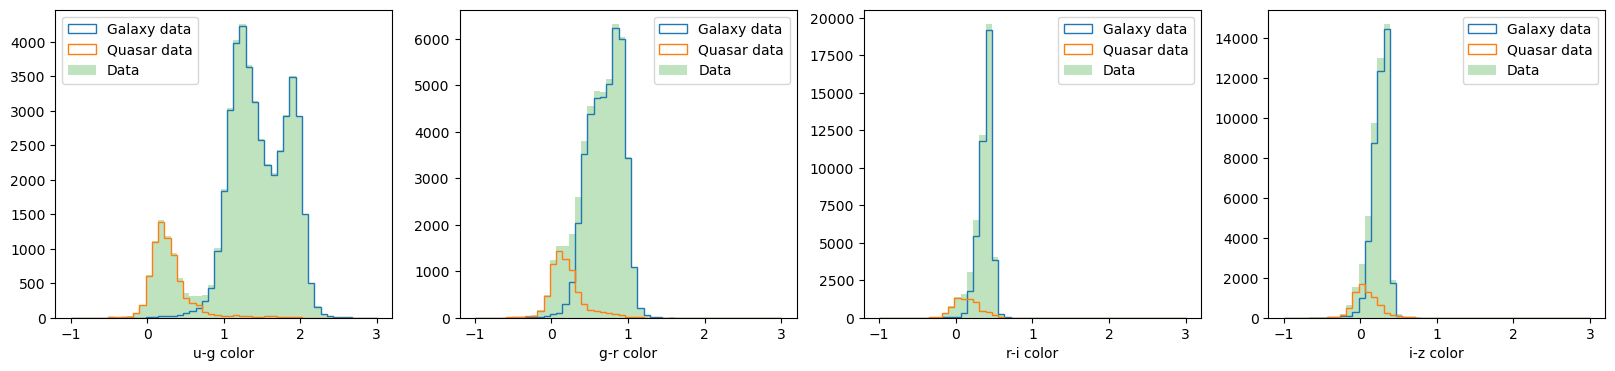

In [119]:
# plots
fig, ax = plt.subplots(1, 4, figsize=(20,4))
bins = np.linspace(-1, 3, 50)

ax[0].hist(ug[class_gq == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(ug[class_gq == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].hist(ug, bins, alpha = 0.3, label = 'Data')
ax[0].legend(loc='upper left')
ax[0].set_xlabel('u-g color')

ax[1].hist(gr[class_gq == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[1].hist(gr[class_gq == 1], bins, histtype = 'step', label = 'Quasar data')
ax[1].hist(gr, bins, alpha = 0.3, label = 'Data')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('g-r color')

ax[2].hist(ri[class_gq == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[2].hist(ri[class_gq == 1], bins, histtype = 'step', label = 'Quasar data')
ax[2].hist(ri, bins, alpha = 0.3, label = 'Data')
ax[2].legend(loc='upper right')
ax[2].set_xlabel('r-i color')

ax[3].hist(iz[class_gq == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[3].hist(iz[class_gq == 1], bins, histtype = 'step', label = 'Quasar data')
ax[3].hist(iz, bins, alpha = 0.3, label = 'Data')
ax[3].legend(loc='upper right')
ax[3].set_xlabel('i-z color')

The data can be distinguished easily in the u-g color, I can observe a good separation between galaxies and quasars.

In [120]:
# train-test splitting
X_data = np.array([ug, gr, ri, iz]).T
print(np.shape(X_data), np.shape(class_gq))
data_train, data_test, class_train, class_test = sklearn.model_selection.train_test_split(X_data, class_gq, test_size=0.2, train_size=0.8)

(50000, 4) (50000,)


# Gaussian Naive Bayes

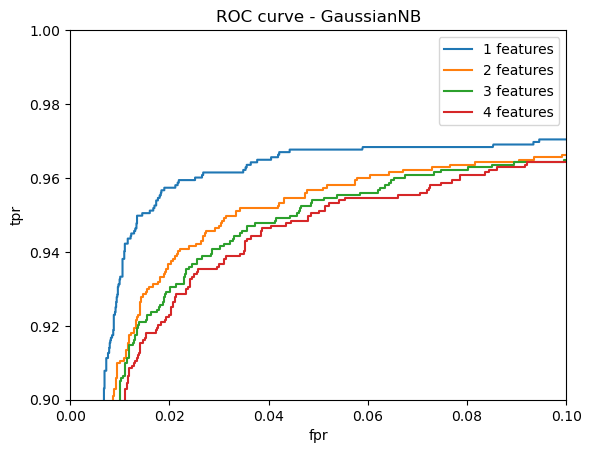

Text(0.5, 0, 'n° features')

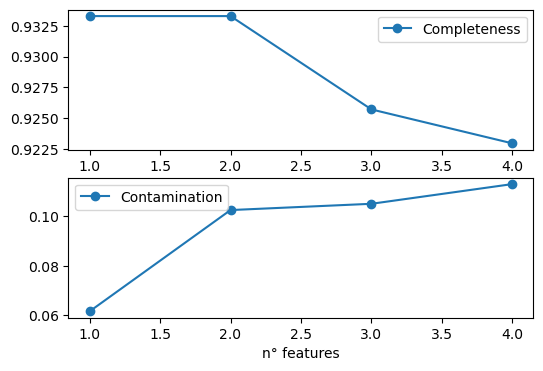

In [121]:
from sklearn.naive_bayes import GaussianNB
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve

completeness_array = []
contamination_array = []

clf = GaussianNB()

# I fit the dataset using different colors: i start with (u-g) and I progressively add other colors.
# In this way I should understand if the (u-g) color is enough to classify the dataset or if I need other features.

for i in range (0, 4):
    X_train = data_train[:,:i+1]
    X_test = data_test[:,:i+1]

    clf.fit(X_train, class_train)
    y_prob = clf.predict_proba(X_test)[:,1]   # I want only the probabilities for the quasars (column [1])
    y_pred = clf.predict(X_test) 
    completeness, contamination = completeness_contamination(y_pred, class_test)
    completeness_array.append(completeness)
    contamination_array.append(contamination)
    fpr, tpr, thresh = roc_curve(class_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+' features')

plt.legend()
plt.title('ROC curve - GaussianNB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.0)
plt.show()

n_features = [1, 2, 3, 4]
fig, ax = plt.subplots(2, 1, figsize=(6,4))

ax[0].plot(n_features, completeness_array, '-o', label = 'Completeness')
ax[0].legend()
ax[1].plot(n_features, contamination_array, '-o', label = 'Contamination')
ax[1].legend()
ax[1].set_xlabel('n° features')

I can observe that the u-g color is enough to classify the data. Let's see if I obtain the same result with other classifiers.

# Linear Discriminant Analysis

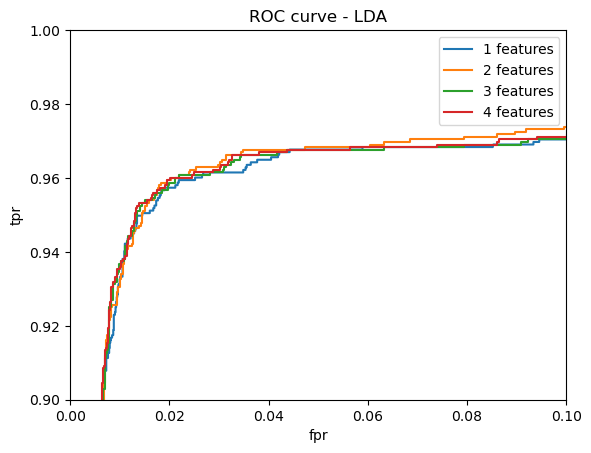

Text(0.5, 0, 'n° features')

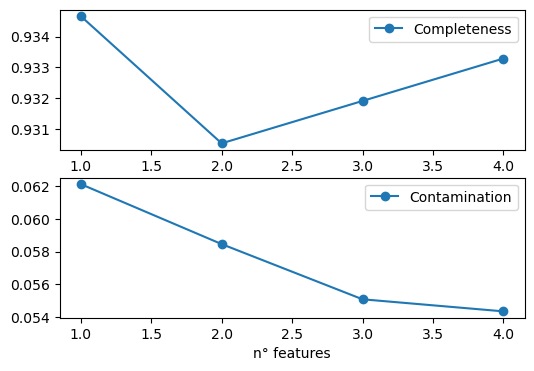

In [122]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

completeness_array = []
contamination_array = []

clf = LDA()

# I fit the dataset using different colors: i start with (u-g) and I progressively add other colors.
# In this way I should understand if the (u-g) color is enough to classify the dataset or if I need other features.

for i in range (0, 4):
    X_train = data_train[:,:i+1]
    X_test = data_test[:,:i+1]

    clf.fit(X_train, class_train)
    y_prob = clf.predict_proba(X_test)[:,1]   # I want only the probabilities for the quasars (column [1])
    y_pred = clf.predict(X_test) 
    completeness, contamination = completeness_contamination(y_pred, class_test)
    completeness_array.append(completeness)
    contamination_array.append(contamination)
    fpr, tpr, thresh = roc_curve(class_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+' features')

plt.legend()
plt.title('ROC curve - LDA')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.0)
plt.show()

n_features = [1, 2, 3, 4]
fig, ax = plt.subplots(2, 1, figsize=(6,4))

ax[0].plot(n_features, completeness_array, '-o', label = 'Completeness')
ax[0].legend()
ax[1].plot(n_features, contamination_array, '-o', label = 'Contamination')
ax[1].legend()
ax[1].set_xlabel('n° features')

Text(0.5, 1.0, 'Predicted labels')

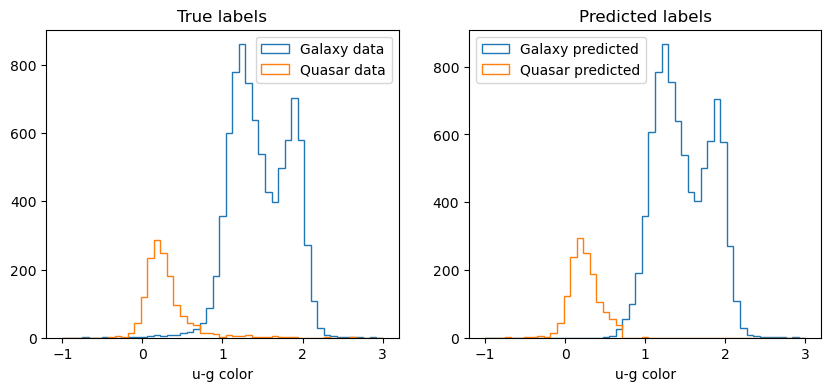

In [123]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 3, 50)
ug = data_test[:,0]

ax[0].hist(ug[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(ug[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('u-g color')
ax[0].set_title('True labels')

ax[1].hist(ug[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(ug[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('u-g color')
ax[1].set_title('Predicted labels')

Text(0.5, 1.0, 'Predicted labels')

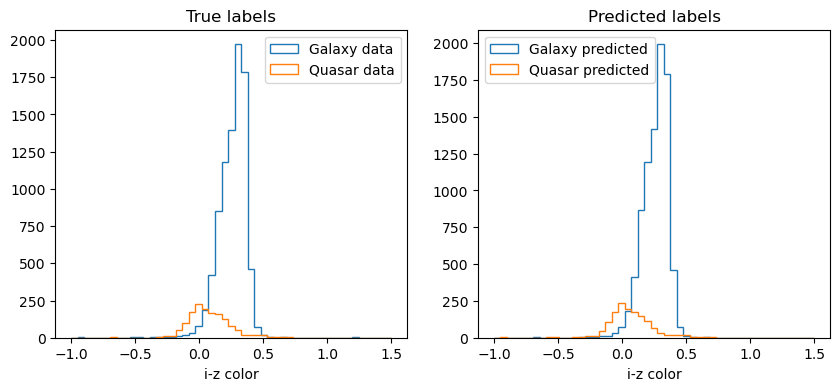

In [124]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 1.5, 50)
iz = data_test[:,3]

ax[0].hist(iz[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(iz[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('i-z color')
ax[0].set_title('True labels')

ax[1].hist(iz[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(iz[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('i-z color')
ax[1].set_title('Predicted labels')

# Quadratic Discriminant Analysis

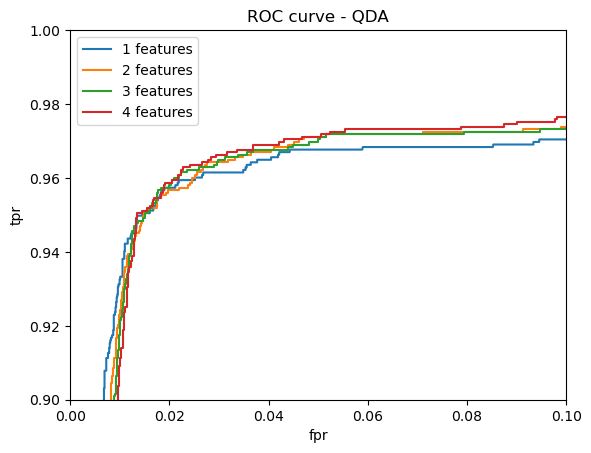

Text(0.5, 0, 'n° features')

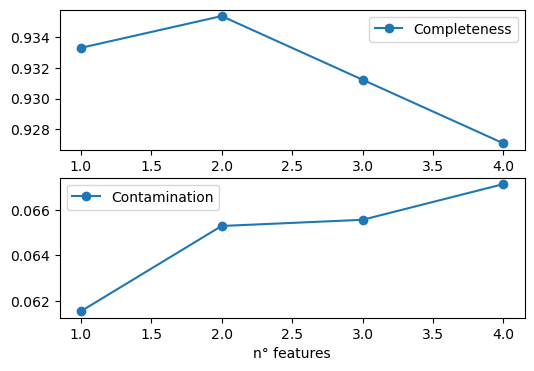

In [125]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

completeness_array = []
contamination_array = []

clf = QDA()

# I fit the dataset using different colors: i start with (u-g) and I progressively add other colors.
# In this way I should understand if the (u-g) color is enough to classify the dataset or if I need other features.

for i in range (0, 4):
    X_train = data_train[:,:i+1]
    X_test = data_test[:,:i+1]

    clf.fit(X_train, class_train)
    y_prob = clf.predict_proba(X_test)[:,1]   # I want only the probabilities for the quasars (column [1])
    y_pred = clf.predict(X_test) 
    completeness, contamination = completeness_contamination(y_pred, class_test)
    completeness_array.append(completeness)
    contamination_array.append(contamination)
    fpr, tpr, thresh = roc_curve(class_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+' features')

plt.legend()
plt.title('ROC curve - QDA')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.0)
plt.show()

n_features = [1, 2, 3, 4]
fig, ax = plt.subplots(2, 1, figsize=(6,4))

ax[0].plot(n_features, completeness_array, '-o', label = 'Completeness')
ax[0].legend()
ax[1].plot(n_features, contamination_array, '-o', label = 'Contamination')
ax[1].legend()
ax[1].set_xlabel('n° features')

Text(0.5, 1.0, 'Predicted labels')

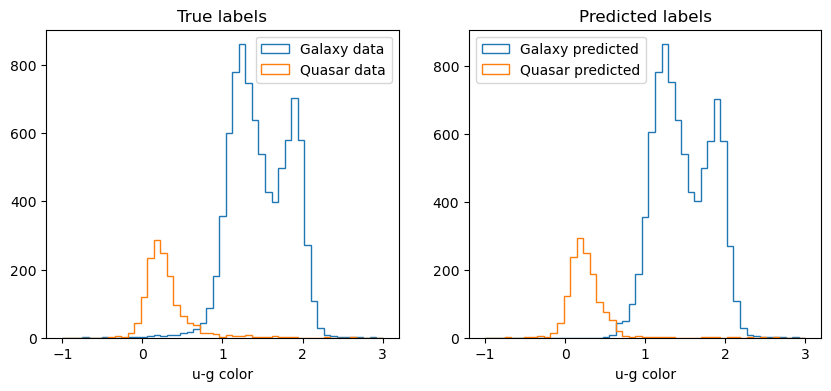

In [126]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 3, 50)
ug = data_test[:,0]

ax[0].hist(ug[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(ug[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('u-g color')
ax[0].set_title('True labels')

ax[1].hist(ug[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(ug[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('u-g color')
ax[1].set_title('Predicted labels')

Text(0.5, 1.0, 'Predicted labels')

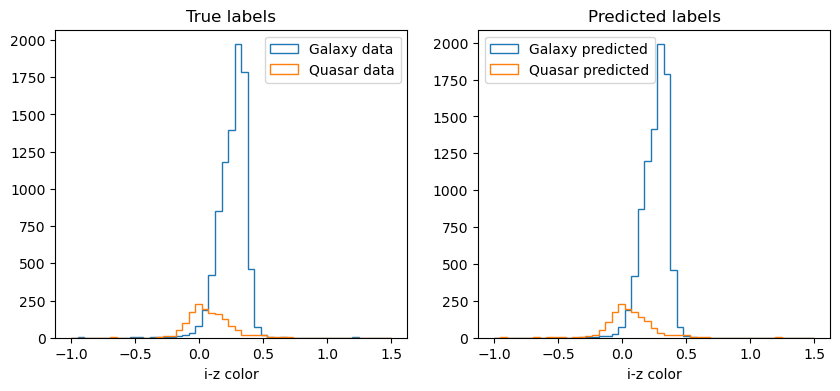

In [127]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 1.5, 50)
iz = data_test[:,3]

ax[0].hist(iz[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(iz[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('i-z color')
ax[0].set_title('True labels')

ax[1].hist(iz[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(iz[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('i-z color')
ax[1].set_title('Predicted labels')

Observing the ROC curves of the LDA and QDA classifiers I can conlude that adding more features can help to obtain a better classification of the dataset.

# GMM Bayes

The maximum accuracy score is for n_components=16


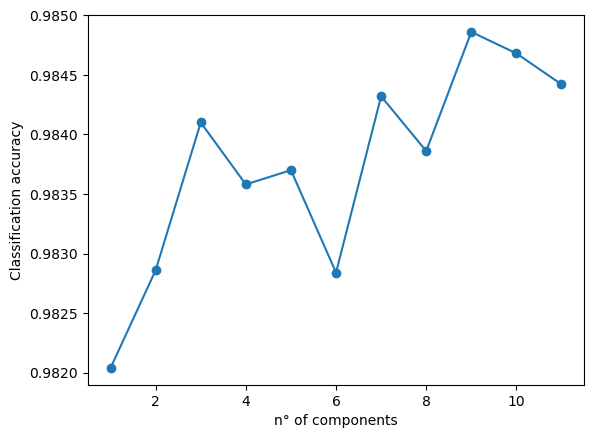

In [ ]:
from astroML.classification import GMMBayes

# At first I perform cross-validation to select the best number of components to use in the GaussianMixture
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

scores = []
kvals = np.arange(8,19)
for k in kvals:
    clf = GMMBayes(n_components=k)
    CVpredk = cross_val_predict(clf, X_data, class_gq)
    scores.append(accuracy_score(class_gq, CVpredk))

print("The maximum accuracy score is for n_components={:d}".format(kvals[np.argmax(scores)]))

# Plot
plt.plot(kvals,scores, '-o')
plt.xlabel('n° of components')
plt.ylabel('Classification accuracy')
plt.show()

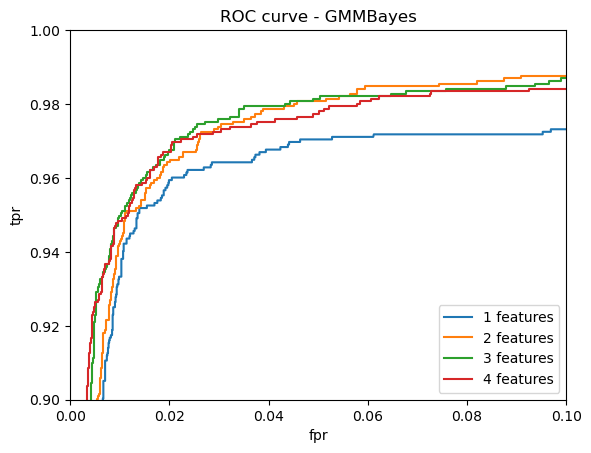

Text(0.5, 0, 'n° features')

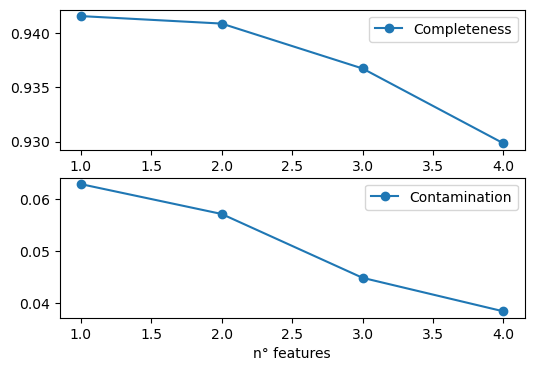

In [129]:
# Now I can analyze the ROC curve using the best number of components
completeness_array = []
contamination_array = []

clf = GMMBayes(n_components=kvals[np.argmax(scores)])

# I fit the dataset using different colors: i start with (u-g) and I progressively add other colors.
# In this way I should understand if the (u-g) color is enough to classify the dataset or if I need other features.

for i in range (0, 4):
    X_train = data_train[:,:i+1]
    X_test = data_test[:,:i+1]

    clf.fit(X_train, class_train)
    y_prob = clf.predict_proba(X_test)[:,1]   # I want only the probabilities for the quasars (column [1])
    y_pred = clf.predict(X_test) 
    completeness, contamination = completeness_contamination(y_pred, class_test)
    completeness_array.append(completeness)
    contamination_array.append(contamination)
    fpr, tpr, thresh = roc_curve(class_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+' features')

plt.legend()
plt.title('ROC curve - GMMBayes')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.0)
plt.show()

n_features = [1, 2, 3, 4]
fig, ax = plt.subplots(2, 1, figsize=(6,4))

ax[0].plot(n_features, completeness_array, '-o', label = 'Completeness')
ax[0].legend()
ax[1].plot(n_features, contamination_array, '-o', label = 'Contamination')
ax[1].legend()
ax[1].set_xlabel('n° features')

Text(0.5, 1.0, 'Predicted labels')

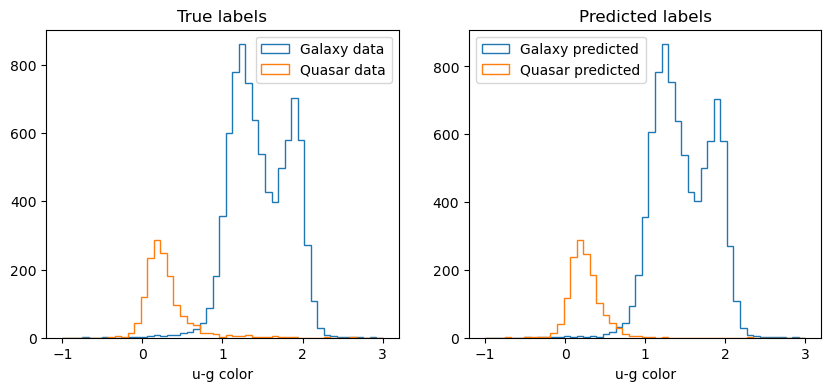

In [130]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 3, 50)
ug = data_test[:,0]

ax[0].hist(ug[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(ug[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('u-g color')
ax[0].set_title('True labels')

ax[1].hist(ug[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(ug[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('u-g color')
ax[1].set_title('Predicted labels')

Text(0.5, 1.0, 'Predicted labels')

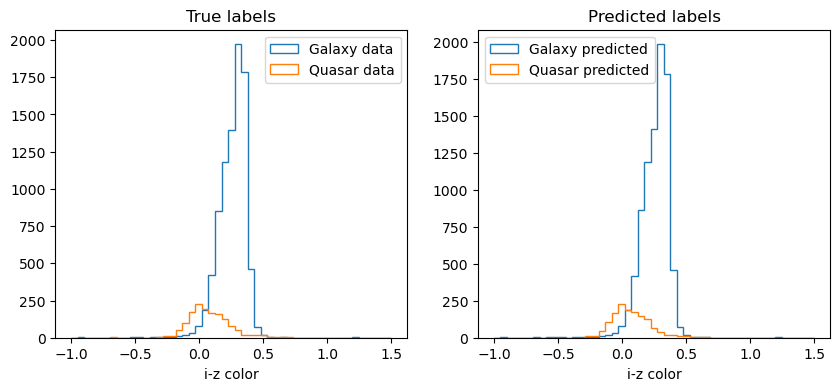

In [131]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 1.5, 50)
iz = data_test[:,3]

ax[0].hist(iz[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(iz[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('i-z color')
ax[0].set_title('True labels')

ax[1].hist(iz[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(iz[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('i-z color')
ax[1].set_title('Predicted labels')

# K-Nearest Neighbor Classifier

The maximum accuracy score is for n_neighbors=9


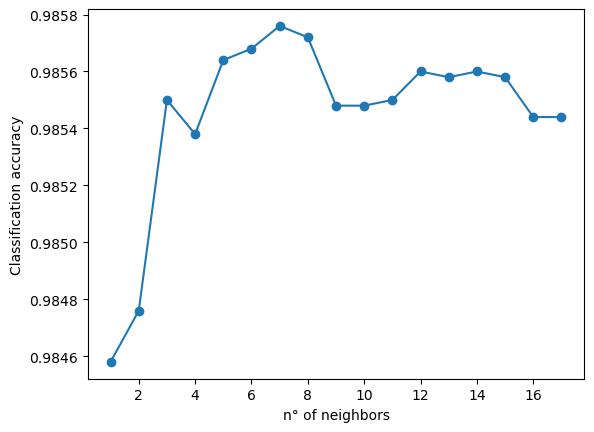

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# At first I perform cross-validation to select the best number of neighbors to use

scores = []
kvals = np.arange(3, 20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_data, class_gq)
    scores.append(accuracy_score(class_gq, CVpredk))

print("The maximum accuracy score is for n_neighbors={:d}".format(kvals[np.argmax(scores)]))

# Plot
plt.plot(kvals,scores, '-o')
plt.xlabel('n° of neighbors')
plt.ylabel('Classification accuracy')
plt.show()

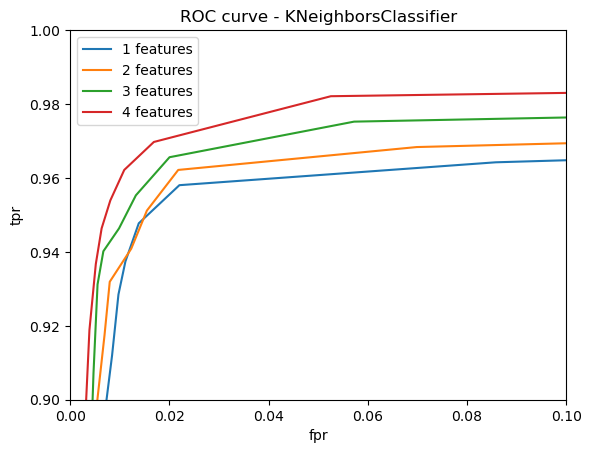

Text(0.5, 0, 'n° features')

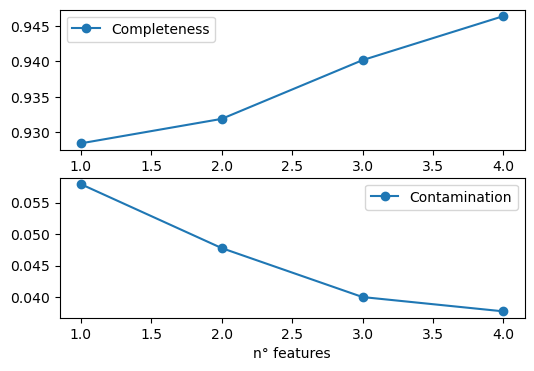

In [133]:
# Now I can analyze the ROC curve using the best number of neighbors
completeness_array = []
contamination_array = []

clf = KNeighborsClassifier(n_neighbors=kvals[np.argmax(scores)])

# I fit the dataset using different colors: i start with (u-g) and I progressively add other colors.
# In this way I should understand if the (u-g) color is enough to classify the dataset or if I need other features.

for i in range (0, 4):
    X_train = data_train[:,:i+1]
    X_test = data_test[:,:i+1]

    clf.fit(X_train, class_train)
    y_prob = clf.predict_proba(X_test)[:,1]   # I want only the probabilities for the quasars (column [1])
    y_pred = clf.predict(X_test) 
    completeness, contamination = completeness_contamination(y_pred, class_test)
    completeness_array.append(completeness)
    contamination_array.append(contamination)
    fpr, tpr, thresh = roc_curve(class_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1)+' features')

plt.legend()
plt.title('ROC curve - KNeighborsClassifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.0)
plt.show()

n_features = [1, 2, 3, 4]
fig, ax = plt.subplots(2, 1, figsize=(6,4))

ax[0].plot(n_features, completeness_array, '-o', label = 'Completeness')
ax[0].legend()
ax[1].plot(n_features, contamination_array, '-o', label = 'Contamination')
ax[1].legend()
ax[1].set_xlabel('n° features')

Text(0.5, 1.0, 'Predicted labels')

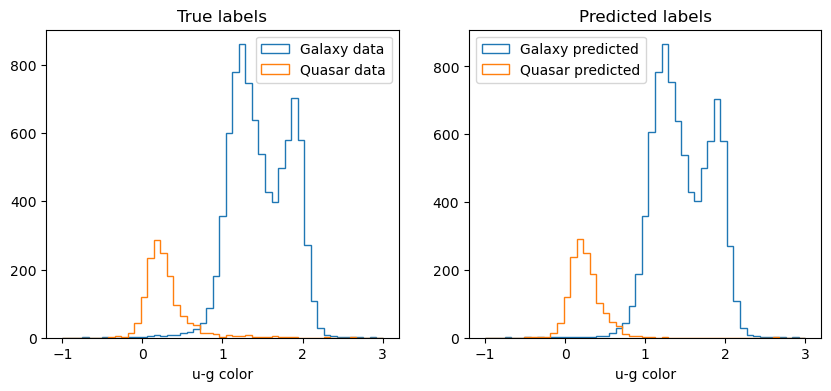

In [134]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 3, 50)
ug = data_test[:,0]

ax[0].hist(ug[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(ug[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('u-g color')
ax[0].set_title('True labels')

ax[1].hist(ug[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(ug[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('u-g color')
ax[1].set_title('Predicted labels')

Text(0.5, 1.0, 'Predicted labels')

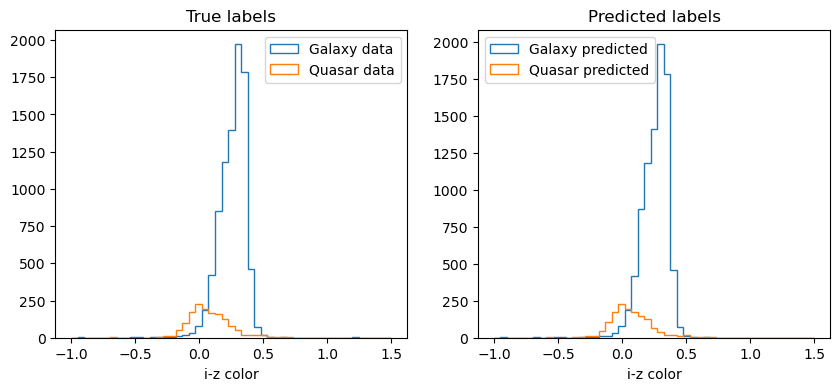

In [135]:
# Histograms to compare the predicted labels and the true ones
fig, ax = plt.subplots(1, 2, figsize=(10,4))
bins = np.linspace(-1, 1.5, 50)
iz = data_test[:,3]

ax[0].hist(iz[class_test == 0], bins, histtype = 'step', label = 'Galaxy data')
ax[0].hist(iz[class_test == 1], bins, histtype = 'step', label = 'Quasar data')
ax[0].legend()
ax[0].set_xlabel('i-z color')
ax[0].set_title('True labels')

ax[1].hist(iz[y_pred == 0], bins, histtype = 'step', label = 'Galaxy predicted')
ax[1].hist(iz[y_pred == 1], bins, histtype = 'step', label = 'Quasar predicted')
ax[1].legend()
ax[1].set_xlabel('i-z color')
ax[1].set_title('Predicted labels')

Observing the ROC curves of the GMMBayes and K-Nearest neighbors classifiers I can conlude that adding more features can help to obtain a better classification of the dataset.